# S06-demo-04 – Инженерный эксперимент: сравнение моделей недели 6

Этот ноутбук – пример **"честного" сравнения моделей** в одном и том же протоколе.  
Цель – не "выжать максимум", а показать, *как инженерно правильно* сравнивать подходы и сохранять результаты так, чтобы их можно было воспроизвести.

## Что вы здесь освоите

- как зафиксировать данные и разбиение `train/test` так, чтобы сравнение было корректным;
- зачем нужны baseline'ы и почему без них легко "обмануться";
- как подбирать гиперпараметры **только на train** через кросс‑валидацию (CV), не заглядывая в тест;
- как сравнивать модели по одинаковым метрикам (accuracy / F1 / ROC‑AUC);
- как сохранять артефакты эксперимента (метрики, параметры, модель) в папку `artifacts/`.

Модели недели 6, которые сравним:

- Decision Tree
- Random Forest
- (Hist) Gradient Boosting
- Stacking (опционально)

## Как работать с ноутбуком

- запускайте ячейки сверху вниз (важно: тут есть общие переменные и артефакты);
- обращайте внимание не только на "лучшую метрику", но и на **стабильность протокола**: где CV, где тест, что и когда считается;
- в конце посмотрите, что появилось в папке `artifacts/` – это часть "инженерного результата".


## 0. Настройки, импорты, пути для артефактов

Мы заранее создаём папку `artifacts/` рядом с ноутбуком – туда будем сохранять:

- таблицу итоговых метрик на тесте;
- лучшие параметры подбора (если был GridSearchCV);
- лучшую модель (через `joblib`) и небольшой JSON‑файл с метаданными.

Такой подход делает эксперимент **воспроизводимым**: вы всегда можете вернуться к результатам, не пересчитывая всё заново.


In [1]:
# Импорты и базовые настройки эксперимента.

# - Фиксируем RANDOM_STATE, чтобы случайные компоненты были воспроизводимыми.
# - Создаём папку artifacts/ – туда будем складывать результаты и модель.

from __future__ import annotations

import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay
)

from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.inspection import permutation_importance

import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

print("Artifacts dir:", ARTIFACTS_DIR.resolve())

Artifacts dir: /content/artifacts


In [2]:
# Вспомогательные функции для эксперимента.

# Здесь нет “обучения” – только сервисные вещи:
# - compute_metrics: считает метрики (accuracy, F1, ROC-AUC при наличии вероятностей)
# - evaluate_on_test: единообразная оценка модели на тесте
# - save_json: аккуратное сохранение артефактов
# - plot_confusion / plot_roc: быстрая диагностика качества

def compute_metrics(y_true, y_pred, y_proba=None) -> dict:
    m = {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "f1": float(f1_score(y_true, y_pred)),
    }
    if y_proba is not None:
        try:
            m["roc_auc"] = float(roc_auc_score(y_true, y_proba))
        except Exception:
            m["roc_auc"] = None
    else:
        m["roc_auc"] = None
    return m

def evaluate_on_test(model, X_test, y_test, label: str) -> dict:
    pred = model.predict(X_test)
    proba = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:, 1]
    metrics = compute_metrics(y_test, pred, proba)
    metrics["model"] = label
    return metrics

def save_json(obj: dict, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

def plot_confusion(y_true, y_pred, title: str):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("pred")
    plt.ylabel("true")
    plt.xticks([0, 1])
    plt.yticks([0, 1])
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.show()

def plot_roc(model, X_test, y_test, title: str):
    if not hasattr(model, "predict_proba"):
        print("ROC: модель не поддерживает predict_proba")
        return
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(title)
    plt.show()

## 1. Данные и фиксированное разбиение train/test

Берём датасет `breast_cancer` из `sklearn` – это табличная бинарная классификация.

Ключевая идея: **разбиение фиксируется один раз** и дальше не меняется.  
Тогда любые различия в метриках объясняются моделями/гиперпараметрами, а не "удачным" разрезом данных.

**Важно:**

- используем `stratify=y`, чтобы доля классов в `train` и `test` была похожей;
- `random_state` фиксирует случайность, чтобы результаты можно было воспроизвести.


In [3]:
# Загрузка датасета и фиксированное разбиение train/test.

# - stratify=y сохраняет пропорции классов в train и test
# - random_state фиксирует случайность разбиения

data = load_breast_cancer()
X = data["data"]
y = data["target"]
feature_names = list(data["feature_names"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y
)

X_train.shape, X_test.shape

((426, 30), (143, 30))

## 2. Baseline’ы

Baseline – это “точка отсчёта”. Если модель недели 6 не обгоняет baseline, то:

- либо она действительно не подходит под задачу,
- либо вы неправильно настроили эксперимент (например, переобучили/недообучили).

Здесь два baseline’а:

1) `DummyClassifier(most_frequent)` – простейшая нижняя планка (угадываем самый частый класс).  
2) `LogisticRegression` – сильный и быстрый baseline из прошлой недели (линейная модель + нормировка признаков).

Для `LogisticRegression` сделаем небольшой **подбор гиперпараметра `C`** на `train` через CV.


In [4]:
# Baseline'ы и подготовка контейнеров для результатов.

# - results: список словарей с метриками на тесте
# - best_models: сюда складываем обученные лучшие модели (чтобы потом их диагностировать/сохранить)
# - search_summaries: сюда складываем лучшие параметры подбора и CV-оценку

# CV = кросс-валидация на train: нужна для подбора гиперпараметров без доступа к тесту.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

results = []
best_models = {}  # label -> fitted best estimator
search_summaries = {}  # label -> краткая инфа о подборе

# 2.1 Dummy baseline (без подбора)

# Dummy baseline: помогает понять, что модель вообще умеет что-то лучше «угадайки».
dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
results.append(evaluate_on_test(dummy, X_test, y_test, "Dummy(most_frequent)"))
best_models["Dummy(most_frequent)"] = dummy

# 2.2 LogisticRegression baseline (с минимальным подбором)

# Логрегрессия почти всегда требует масштабирования признаков, поэтому используем Pipeline со StandardScaler.
lr = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=4000, random_state=RANDOM_STATE))
])


# Подбираем C (обратная сила регуляризации): меньше C -> сильнее регуляризация -> проще модель.
lr_grid = {
    "lr__C": [0.1, 1.0, 10.0],
    "lr__penalty": ["l2"],
    "lr__solver": ["lbfgs"],
}


# GridSearchCV перебирает сетку параметров и оценивает качество по CV. scoring=roc_auc – метрика для бинарной классификации по вероятностям.
lr_search = GridSearchCV(
    lr, lr_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=True
)
lr_search.fit(X_train, y_train)

best_lr = lr_search.best_estimator_
best_models["LogReg(scaled)"] = best_lr

search_summaries["LogReg(scaled)"] = {
    "best_params": lr_search.best_params_,
    "best_cv_roc_auc": float(lr_search.best_score_),
}

results.append(evaluate_on_test(best_lr, X_test, y_test, "LogReg(scaled)"))

search_summaries["LogReg(scaled)"]

{'best_params': {'lr__C': 1.0, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'},
 'best_cv_roc_auc': 0.9961506165325398}

## 3. Кандидаты недели 6: дерево, лес, бустинг

Сравним три семейства моделей:

- **Decision Tree** – простая нелинейность, быстро обучается, легко переобучается без ограничений.
- **Random Forest** – ансамбль деревьев, обычно устойчивее и сильнее одного дерева.
- **HistGradientBoosting** – градиентный бустинг (часто даёт высокое качество на табличных данных).

Протокол подбора:

- гиперпараметры подбираем через `GridSearchCV` **только на train**;
- метрику для подбора берём `roc_auc` (она хорошо работает для бинарной классификации, когда важна “сортировка” вероятностей);
- тест используем **ровно один раз** – для финальной честной оценки лучших моделей.


In [5]:
# Единая функция для подбора гиперпараметров через GridSearchCV.

# Она:
# - обучает GridSearchCV на X_train/y_train
# - кладёт лучшую модель и summary в словари
# - добавляет финальную оценку на тесте в results

def run_search(label: str, estimator, param_grid: dict):
    search = GridSearchCV(
        estimator,
        param_grid,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        refit=True,
        return_train_score=True
    )
    search.fit(X_train, y_train)

    best = search.best_estimator_
    best_models[label] = best
    search_summaries[label] = {
        "best_params": search.best_params_,
        "best_cv_roc_auc": float(search.best_score_),
    }
    results.append(evaluate_on_test(best, X_test, y_test, label))
    return search

In [6]:
# Decision Tree: одна модель дерева решений.

# Что обычно делает дерево “сложнее” и склоннее к переобучению:
# - большой max_depth
# - маленький min_samples_leaf
# ccp_alpha – параметр cost-complexity pruning (штраф за сложность).

# 3.1 Decision Tree
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)

dt_grid = {
    "max_depth": [None, 3, 5, 8],
    "min_samples_leaf": [1, 5, 10, 20],
    "ccp_alpha": [0.0, 0.001, 0.005, 0.01],
}

dt_search = run_search("DecisionTree", dt, dt_grid)
search_summaries["DecisionTree"]

{'best_params': {'ccp_alpha': 0.0, 'max_depth': 3, 'min_samples_leaf': 20},
 'best_cv_roc_auc': 0.9653705535267463}

In [7]:
# Random Forest: ансамбль деревьев (bagging).

# Идеи:
# - много деревьев (n_estimators) снижает дисперсию
# - max_features добавляет разнообразие деревьев (важно для ансамблей)
# - ограничения глубины/листа помогают контролировать переобучение

# 3.2 Random Forest
rf = RandomForestClassifier(
    n_estimators=600,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    oob_score=False
)

rf_grid = {
    "max_depth": [None, 6, 10],
    "min_samples_leaf": [1, 5, 10],
    "max_features": ["sqrt", 0.5],
}

rf_search = run_search("RandomForest", rf, rf_grid)
search_summaries["RandomForest"]

{'best_params': {'max_depth': None,
  'max_features': 'sqrt',
  'min_samples_leaf': 1},
 'best_cv_roc_auc': 0.9888945244696916}

In [8]:
# HistGradientBoosting: градиентный бустинг по гистограммам (быстро и часто качественно).

# Ключевые “ручки”:
# - learning_rate: шаг обучения (меньше -> аккуратнее, часто нужно больше итераций)
# - max_depth / max_leaf_nodes: сложность базовых деревьев
# early_stopping=True включает остановку по внутренней валидации на train.

# 3.3 HistGradientBoosting (быстрый градиентный бустинг в sklearn)
hgb = HistGradientBoostingClassifier(
    random_state=RANDOM_STATE,
    early_stopping=True
)

hgb_grid = {
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [2, 3, None],
    "max_leaf_nodes": [15, 31, 63],
}

hgb_search = run_search("HistGradientBoosting", hgb, hgb_grid)
search_summaries["HistGradientBoosting"]

{'best_params': {'learning_rate': 0.1,
  'max_depth': None,
  'max_leaf_nodes': 15},
 'best_cv_roc_auc': 0.9913643882013481}

## 4. (Опционально) Stacking

**Stacking** – это ансамбль “разных” моделей, где поверх их предсказаний обучается метамодель (здесь – логистическая регрессия).

Зачем это нужно:

- иногда разные модели ошибаются по‑разному;
- метамодель учится комбинировать их сильные стороны.

Важно понимать:

- `StackingClassifier` внутри использует CV, чтобы собрать обучающие данные для метамодели корректно (без “подглядывания”).
- В реальных проектах стекинг часто требует аккуратной настройки и контроля переобучения, поэтому здесь он идёт как опциональный шаг.


In [9]:
# Stacking (опционально): ансамбль из нескольких уже обученных моделей + метамодель.

# - estimators: базовые модели (их предсказания идут на вход метамодели)
# - final_estimator: метамодель (здесь логистическая регрессия)
# - cv=5: CV внутри стекинга, чтобы метамодель училась без утечки

estimators = [
    ("lr", best_models["LogReg(scaled)"]),
    ("rf", best_models["RandomForest"]),
    ("hgb", best_models["HistGradientBoosting"]),
]

stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=4000, random_state=RANDOM_STATE),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# Стекинг обычно имеет мало “ручек”, поэтому без GridSearch – просто честная оценка
stack.fit(X_train, y_train)
best_models["Stacking"] = stack
results.append(evaluate_on_test(stack, X_test, y_test, "Stacking"))

{"note": "stacking fitted"}

{'note': 'stacking fitted'}

## 5. Сводка результатов (test)

Соберём все результаты в таблицу и отсортируем модели:

- сначала по `ROC‑AUC` (если он посчитан),
- иначе по `accuracy`.

Как читать метрики:

- **accuracy**: доля верных ответов (может быть “обманчивой” при сильном дисбалансе классов);
- **F1**: баланс точности и полноты для положительного класса;
- **ROC‑AUC**: качество ранжирования вероятностей (чем ближе к 1.0, тем лучше).

Сравнивайте модели по *одной и той же метрике* и держите в голове, *зачем* вы её используете.


In [10]:
# Сводка результатов в таблицу.

# Обратите внимание:
# - ROC-AUC может быть None (если модель не выдаёт вероятности)
# - поэтому для сортировки создаём временный столбец roc_auc_sort

df = pd.DataFrame(results)

# сортировка: roc_auc (если есть) иначе accuracy
df_sorted = df.copy()
df_sorted["roc_auc_sort"] = df_sorted["roc_auc"].fillna(-1.0)
df_sorted = df_sorted.sort_values(["roc_auc_sort", "accuracy"], ascending=False).drop(columns=["roc_auc_sort"])

df_sorted

,accuracy,f1,roc_auc,model
5,0.979021,0.983425,0.997904,Stacking
1,0.986014,0.988889,0.997694,LogReg(scaled)
4,0.972028,0.978022,0.994969,HistGradientBoosting
3,0.958042,0.967033,0.994340,RandomForest
2,0.916084,0.930233,0.962683,DecisionTree
0,0.629371,0.772532,0.500000,Dummy(most_frequent)


Сохраним:

- финальную таблицу метрик на тесте;
- информацию о подборе (лучшие параметры и лучшая CV‑оценка).

Это делает эксперимент “закрытым циклом”: результаты есть и на экране, и в файлах.


In [11]:
# Сохранение артефактов эксперимента в artifacts/.

# После выполнения этой ячейки можно открыть папку artifacts/ и увидеть:
# - metrics_test.json (итоговые метрики)
# - search_summaries.json (лучшие параметры подбора)

metrics_path = ARTIFACTS_DIR / "metrics_test.json"
search_path = ARTIFACTS_DIR / "search_summaries.json"

save_json({"results": df_sorted.to_dict(orient="records")}, metrics_path)
save_json(search_summaries, search_path)

print("Saved:", metrics_path)
print("Saved:", search_path)

Saved: artifacts/metrics_test.json
Saved: artifacts/search_summaries.json


## 6. Лучшая модель: диагностика на тесте (confusion matrix + ROC)

После сортировки выберем “лучшую” модель (по `ROC‑AUC`, если он есть).

Дальше сделаем быструю диагностику:

- **confusion matrix** показывает, где именно модель ошибается (FP/FN);
- **ROC‑кривая** показывает качество ранжирования вероятностей по всем порогам.

Важно: это диагностика **после** всех подборов, на тесте. Мы не меняем модель по тесту – только оцениваем.


In [12]:
# Выбор “лучшей” модели по таблице результатов.

# Важно: мы НЕ переобучаем и не меняем модель по тесту.
# Мы только выбираем, какую модель будем диагностировать и сохранять.

best_row = df_sorted.iloc[0]
best_label = best_row["model"]
best_model = best_models[best_label]

best_label, best_row.to_dict()

('Stacking',
 {'accuracy': 0.9790209790209791,
  'f1': 0.9834254143646409,
  'roc_auc': 0.9979035639412999,
  'model': 'Stacking'})

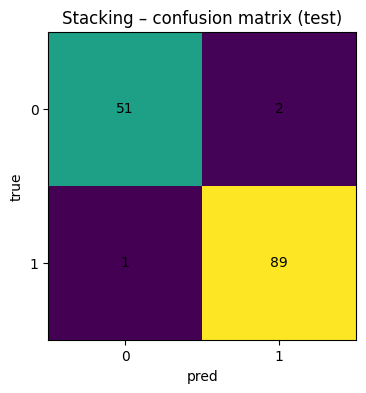

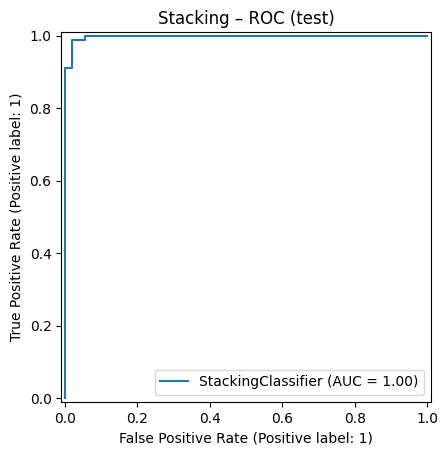

In [13]:
# Диагностика на тесте: confusion matrix и ROC-кривая.

# Confusion matrix помогает понять тип ошибок (FP/FN),
# ROC показывает качество ранжирования вероятностей по всем порогам.

y_pred = best_model.predict(X_test)
plot_confusion(y_test, y_pred, title=f"{best_label} – confusion matrix (test)")
plot_roc(best_model, X_test, y_test, title=f"{best_label} – ROC (test)")

## 7. Интерпретация: permutation importance (top‑15)

Permutation importance отвечает на вопрос:

> “Если случайно перемешать один признак, насколько сильно ухудшится качество модели?”

Если качество падает сильно – признак важен. Если почти не меняется – признак малозначим (для этой модели и этой метрики).

Ограничения метода (это нормально, просто держите в голове):

- при сильной корреляции признаков важность “размазывается”;
- результат зависит от выбранной метрики (здесь `roc_auc` или `accuracy`);
- из‑за случайности (перемешивания) стоит делать несколько повторов (`n_repeats`).


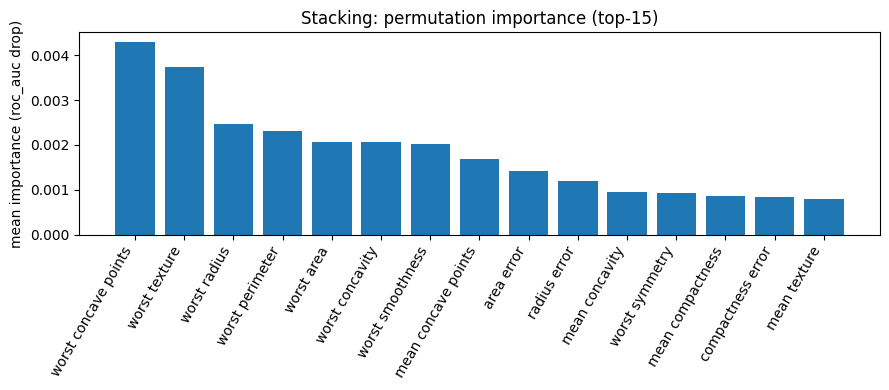

In [14]:
# Permutation importance на тесте (top-15).

# Идея: перемешиваем один признак и смотрим, насколько падает качество.
# Чем больше падение, тем “важнее” признак для модели.

scoring = "roc_auc" if hasattr(best_model, "predict_proba") else "accuracy"

perm = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=8,
    random_state=RANDOM_STATE,
    scoring=scoring
)

imp = perm.importances_mean
idx = np.argsort(imp)[::-1][:15]

plt.figure(figsize=(9, 4))
plt.bar(range(len(idx)), imp[idx])
plt.xticks(range(len(idx)), [feature_names[i] for i in idx], rotation=60, ha="right")
plt.ylabel(f"mean importance ({scoring} drop)")
plt.title(f"{best_label}: permutation importance (top-15)")
plt.tight_layout()
plt.show()

## 8. Сохранение лучшей модели

Сохраним лучшую модель в `artifacts/best_model.joblib`.

Рядом положим `best_model_meta.json` – небольшой файл, где зафиксируем:

- какая именно модель оказалась лучшей;
- её метрики на тесте;
- результаты подбора гиперпараметров (если они были);
- `random_state`, чтобы было проще воспроизвести эксперимент.


In [15]:
# Сохранение лучшей модели и метаданных.

# - best_model.joblib: сериализованная модель
# - best_model_meta.json: “паспорт” результата (какая модель, какие метрики, какие параметры)

model_path = ARTIFACTS_DIR / "best_model.joblib"
joblib.dump(best_model, model_path)

meta = {
    "best_model_label": best_label,
    "test_metrics": best_row.to_dict(),
    "search_summary": search_summaries.get(best_label, None),
    "random_state": RANDOM_STATE,
}
save_json(meta, ARTIFACTS_DIR / "best_model_meta.json")

print("Saved:", model_path)
print("Saved:", ARTIFACTS_DIR / "best_model_meta.json")

Saved: artifacts/best_model.joblib
Saved: artifacts/best_model_meta.json


## 9. Итоги (коротко)

- Мы сравнили baseline’ы и модели недели 6 в **едином и честном протоколе**.
- Подбор гиперпараметров делали через CV **только на train**.
- Тест использовали один раз – для финальной оценки, без “дотюнинга” по тесту.
- Артефакты эксперимента сохранили в `artifacts/`: метрики, параметры подбора, лучшая модель и метаданные.
